In [8]:

import os.path

import torch
from torchvision import transforms, datasets, models
import torchvision
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from torchvision.io import read_image
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [9]:
# matplotlib.use("TkAgg")
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [55]:
def get_model(outfeature):
    model_pre = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    # model_pre = models.resnet50(pretrained=True)
    # model_pre = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model_pre.parameters():
        param.requires_grad = True
    num_ftrs = model_pre.fc.in_features
    print(num_ftrs)
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    # model_pre.fc = nn.Linear(num_ftrs, outfeature)
    model_pre.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, outfeature),
    nn.LogSoftmax(dim=1)
)
    return model_pre

In [68]:
def train(model, device, train_loader, criterion, optimizer, scheduler,epoch, writer,name):
    model.train()
    model = model.to(device)
    total_loss = 0.0  # 初始化
    correct = 0.0
    totel_train = 0.0
    for batch_id, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, preds = torch.max(output, dim=1)
        correct += torch.sum(preds == target)
        totel_train +=len(data)
    accuracy = correct / totel_train
    writer.add_scalar(name+"--Train loss", total_loss , epoch)
    writer.add_scalar(name+"--Train accuracy", accuracy, epoch)
    writer.flush()
    scheduler.step()
    return total_loss,accuracy

def test(model, device, test_loader, criterion, epoch, dt,writer,name):
    model.eval()
    total_loss = 0.0
    correct = 0.0
    totel_test = 0.0
    with torch.no_grad():
        for batch_id, (data, target) in enumerate(test_loader):
        # for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            _, preds = torch.max(output, dim=1)
            correct += torch.sum(preds == target)
            totel_test +=len(data)
        # total_loss /= totel_test
        accuracy = correct / totel_test
        writer.add_scalar(name+"--Test loss", total_loss, epoch)
        writer.add_scalar(name+"--Test accuracy", accuracy, epoch)
        writer.flush()
        print("Test_Accuracy:{:.4f}".format(accuracy))
        if accuracy>=bestmodel[dt]["test_acc"]:
            print("最佳预测结果：")
            print(int(correct),'--',totel_test)
            return total_loss,accuracy
        else:
            return '',''


In [78]:

def main(num_epochs,batch_size,dt,dp,name,r):
    writer = SummaryWriter("./logs/"+dt)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    print(type(device))
    if resnet==50:
        data_transforms = {
            "train": transforms.Compose(
                [
                    transforms.Resize(
                        256,
                    ),
                    transforms.CenterCrop(224),
                    # transforms.Resize(
                    #     64,
                    # ),
                    # transforms.CenterCrop(224),
                    # transforms.CenterCrop(64),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            )
            # "valid": transforms.Compose(
            #     [
            #         transforms.Resize(250),
            #         transforms.CenterCrop(64),
            #         transforms.ToTensor(),
            #         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            #     ]
            # ),
        }
    else:
        data_transforms = {
            "train": transforms.Compose(
                [
                    transforms.Resize(
                        256,
                    ),
                    transforms.CenterCrop(224),
                    transforms.Resize(
                        64,
                    ),
                    # transforms.CenterCrop(224),
                    # transforms.CenterCrop(64),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            )
        }  
    # image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x])
    #     for x in ["train", "valid"]
    # }
    # dataloaders = {
    #     x: torch.utils.data.DataLoader(
    #         dataset=image_datasets[x], batch_size=batch_size, shuffle=True
    #     )
    #     for x in ["train", "valid"]
    # }
    # data_size = {x: len(image_datasets[x]) for x in ["train", "valid"]}
    all_datasets = datasets.ImageFolder(dp,data_transforms['train'])
    print(len(all_datasets))
    print(all_datasets.classes)
    outfeatures = len(all_datasets.classes)
    print(outfeatures)
    train_num,valid_num = int(len(all_datasets)*r),len(all_datasets)-int(len(all_datasets)*r)
    print("训练数据:%d,验证数据：%d"%(train_num,valid_num))
    image_datasets={}
    image_datasets["train"], image_datasets["valid"] = torch.utils.data.random_split(all_datasets, [train_num,valid_num])
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
        for x in ["train", "valid"]
    }
    data_size = {x: len(image_datasets[x]) for x in ["train", "valid"]}
    images, targets = next(iter(dataloaders["train"]))
    print(targets)
    out = make_grid(images, nrow=4, padding=10)
    show(out)
    model = get_model(outfeatures)
    # print(model)
    # summary(model,(3,64,64))
    # 优化器
    optim_fit = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optim_fit, step_size=10, gamma=0.1)
    # criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    # print(len(dataloaders['train']))
    print(len(dataloaders['valid']))
    for epoch in range(num_epochs):
        print("训练迭代：%d" % epoch)
        train_loss,train_acc = train(model, device, dataloaders["train"], criterion, optim_fit,scheduler, epoch, writer,name)
        test_loss,test_acc = test(model, device, dataloaders["valid"], criterion, epoch, dt,writer,name)
        print(test_acc)
        if test_acc :
            bestmodel[dt]["model"]= model
            bestmodel[dt]["train_loss"] = train_loss
            bestmodel[dt]["train_acc"] = train_acc
            bestmodel[dt]["test_loss"] = test_loss
            bestmodel[dt]["test_acc"] = test_acc
            bestmodel[dt]["epoch"] = 0
            print("Train Loss:{:.4f},Accuracy:{:.4f}".format(train_loss, train_acc))
            print("Test Loss:{:.4f},Accuracy:{:.4f}".format(test_loss, test_acc))


agingregin_200resnet50_V1_CrossEntropyLoss_224_oe
cuda
<class 'torch.device'>
190
['CK01', 'CK03', 'CK05', 'DZ01', 'DZ03', 'DZ05', 'DZ10', 'NT01', 'NT03', 'NT05', 'NT10', 'SJ01', 'SJ03', 'SJ05', 'SS01', 'SS03', 'SS05', 'SS10']
18
训练数据:114,验证数据：76
tensor([ 8, 12,  9,  3,  0,  4, 15,  3,  5, 14,  7, 12,  2,  8, 15, 10, 17,  4,
         8, 11])


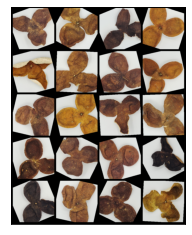

512
4
训练迭代：0
Test_Accuracy:0.0526
最佳预测结果：
4 -- 76.0
tensor(0.0526, device='cuda:0')
Train Loss:17.5846,Accuracy:0.0702
Test Loss:11.3985,Accuracy:0.0526
训练迭代：1
Test_Accuracy:0.0789
最佳预测结果：
6 -- 76.0
tensor(0.0789, device='cuda:0')
Train Loss:14.7657,Accuracy:0.2105
Test Loss:13.9665,Accuracy:0.0789
训练迭代：2


In [ ]:
if __name__ == "__main__":
    global bestmodel
    bestmodel = {}
    origins = ["CK","DZ","NT","JS","SS","agingregin"]
    for origin in origins:
        bestmodel[origin]={"test_acc":0}
    origins = ["agingregin"]
    # dt = "regin"
    # dt = "agingregin"
    # dt = "aging"
    num_epochs = 200
    batch_size = 20
    rgard = True
    r = 0.6
    # for dt in ["aging/CK","aging/DZ","aging/NT","aging/SJ","aging/SS","agingregin","regin"]:
        # if dt != "agingregin":
    peel = "oe"
    global resnet
    resnet = 50
    for origin in origins:
        if resnet==50:
            name = origin+'_'+str(num_epochs)+'resnet50_V1_CrossEntropyLoss_224_' + peel
        else:
            name = origin+'_'+str(num_epochs)+'resnet18_V1_CrossEntropyLoss_64_' + peel
        dp = os.path.join("./data/ie/aging",origin)
        dp = os.path.join("./data",peel,origin)
        # name = dt+'_'+str(num_epochs)+'resnet50_V1_900_256_224_ie'
        print(name)
        main(num_epochs,batch_size,origin,dp,name,r)
        torch.save(bestmodel[origin],"models/{}18{}.pkl".format(origin,peel))

4

In [76]:
1+1

2

In [1]:
!pip install torch-summary

/usr/bin/sh: line 1: pip: command not found
